EMbeta_TAP-sigma.ipynb との違い

ファイルを読み込むことでモンテカルロサンプリングの初期値を途中から行える

i.e. T=1000step　の値を初期値にして計算可能

In [48]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import math

plt.style.use('ggplot')

読み込みファイル，計算に使用するデータ数，モンテカルロステップ数`T`，逆温度$\beta$(配列),モンテカルロサンプル数`sample`を指定．

`epsilon` と `length` は今後の計算に必要．

In [49]:
data_file = 'TAP_artificial_data_De=1.5_ka=20_kd=5_sigma=5e-6_1-10^4ms.dat'
read_file = 'EM_TAP_test_M11_sigma_0.dat'
data_points = 100
T = 10
sample = 1
#model = 0.1*np.arange(0, 11, 2, dtype=float)
#model = 0.1*np.arange(0, 11, dtype=float)
#model = 0.01*np.arange(0, 101, 5, dtype=float)
#print(model)

beta = np.array([1, 0.5, 0.1])
temp = 1/beta

# true_diffusivity = 1.5
# true_k_a = 20.0
# true_k_d = 5.0
# true_standard_deviation = 5e-6
epsilon = 1.0
length = 35.0

## 2つのモデル

$M=0$ : 拡散のみ

* Dimensionless form

\begin{align}
    &\frac{\partial \bar{C}_{A}}{\partial \tau} = \frac{\partial^{2} \bar{C}_{A}}{\partial \xi^{2}} \\
    \Longrightarrow\, &\bar{F}_{A} = \sum_{n=0}^{\infty}\left(-1\right)^{n}\left(2n+1\right)\exp \left(-\left(n+\frac{1}{2}\right)^{2}\pi^{2}\tau\right)
\end{align}

$M=1$ : 拡散+吸着+脱離

* Dimensionless form

\begin{align}
    &\frac{\partial \bar{C}_{A}}{\partial \tau} = \frac{\partial^{2} \bar{C}_{A}}{\partial \xi^{2}}-\bar{k}_{a}\bar{C}_{A}+\bar{k}_{d}\bar{\theta}_{A}, \\
    &\frac{\partial \bar{\theta}_{A}}{\partial \tau} = \bar{k}_{a}\bar{C}_{A}-\bar{k}_{d}\bar{\theta}_{A}
\end{align}

\begin{align}
    \Longrightarrow\,&\bar{F}_{A} = \pi\sum_{n=0}^{\infty}\left(-1\right)^{n}\left(2n+1\right)\left[A_{n}\exp \left(r_{-}\tau\right)+\left(1-A_{n}\right)\exp \left(r_{+}\tau\right)\right]
\end{align}

ただし

\begin{align}
    &r_{\pm} = \frac{-\left(p_{n}^{2}+\bar{k}_{a}+\bar{k}_{d}\right)\pm\sqrt{\left(p_{n}^{2}+\bar{k}_{a}+\bar{k}_{d}\right)^{2}-4p_{n}^{2}\bar{k}_{d}}}{2}, \\
    &p_{n} = \left(n+\frac{1}{2}\right)\pi, \\
    &A_{n} = \frac{r_{+}+p_{n}^{2}+\bar{k}_{a}}{r_{+}-r_{-}}
\end{align}

dimensional form と dimensionless form の関係は

\begin{align}
    &\tau = \frac{D_{eA}}{\epsilon_{b}L^{2}}t, \\
    &\bar{F}_{A}\left(\xi, \tau \right) = \frac{\epsilon_{b}L^{2}}{D_{eA}}\frac{F_{A}\left(x, t\right)}{N_{pA}}
\end{align}

## 関数
```python:title
Flow(diffusivity, k_a, k_d, epsilon, length, time)
```
高速版
* 入力 : $D_{e}, k_{a}, k_{d}, \epsilon_{b}, L$ (スカラー), $t$ (numpy配列)
* 出力 : $t$と同じ次元のDimensional flow

`k_a=0, k_d=0`で $M=0$,それ以外で $M=1$ になる．

In [50]:
def p_n(n):
    return (n+0.5)*np.pi

def r_plus(p_n, k_a, k_d):
    return ( -(p_n**2 + k_a + k_d)+np.sqrt((p_n**2 + k_a + k_d)**2 - 4*(p_n**2)*k_d) )/2.0

def r_minus(p_n, k_a, k_d):
    return ( -(p_n**2 + k_a + k_d)-np.sqrt((p_n**2 + k_a + k_d)**2 - 4*(p_n**2)*k_d) )/2.0

def A_n(p_n, r_plus, r_minus, k_a):
    return (r_plus + (p_n**2) + k_a)/(r_plus - r_minus)

# def Flow(diffusivity, k_a, k_d, epsilon, length, time):
#     dimensionless_time = time * diffusivity/(epsilon*length**2)
    
#     f_flow = np.zeros(time.shape[0])
#     pn = p_n(0); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
#     A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
#     f_flow += np.power(-1.0, 0)*(2.0*0+1.0)*( A*np.exp(r_m*dimensionless_time)+(1.0-A)*np.exp(r_p*dimensionless_time) )
    
#     l_flow = np.zeros(time.shape[0])
#     pn = p_n(1); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
#     A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
#     l_flow = f_flow + np.power(-1.0, 1)*(2.0*1+1.0)*( A*np.exp(r_m*dimensionless_time)+(1.0-A)*np.exp(r_p*dimensionless_time) )
    
#     N = np.ones(time.shape[0], dtype=int)

#     for i in range(time.shape[0]):
#         while np.abs((l_flow[i]-f_flow[i])/f_flow[i]) > 10**-5:
#             N[i] += 1
#             f_flow[i] = l_flow[i]
#             pn = p_n(N[i]); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
#             A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
#             l_flow[i] += np.power(-1.0, N[i])*(2.0*N[i]+1.0)*( A*np.exp(r_m*dimensionless_time[i])+(1.0-A)*np.exp(r_p*dimensionless_time[i]) )
    
##     while np.abs((l_flow[0]-f_flow[0])/f_flow[0]) > 10**-5:
##         for i in range(time.shape[0]):
##             if np.abs((l_flow[i]-f_flow[i])/f_flow[i]) > 1.*10**-5:
##                 N[i] += 1
##                 f_flow[i] = l_flow[i]
##                 pn = p_n(N[i]); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
##                 A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
##                 l_flow[i] += np.power(-1.0, N[i])*(2.0*N[i]+1.0)*( A*np.exp(r_m*dimensionless_time[i])+(1.0-A)*np.exp(r_p*dimensionless_time[i]) )
    
# #    print(N)
#     l_flow *= np.pi
#     l_flow *= diffusivity/(epsilon*np.power(length, 2))

#     return l_flow

def Flow(diffusivity, k_a, k_d, epsilon, length, time):
    dimensionless_time = time * diffusivity/(epsilon*length**2)
    r_flow = np.zeros(len(time))
    for n in range(100):
        pn = p_n(n); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
        A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
        r_flow += np.power(-1.0,n)*(2.0*n+1.0)*( A*np.exp(r_m*dimensionless_time)+(1.0-A)*np.exp(r_p*dimensionless_time) )
    r_flow *= np.pi
    r_flow *= diffusivity/(epsilon*np.power(length, 2))

    return r_flow

以下の `cell` でファイルからデータを読み込む．

100 	 100


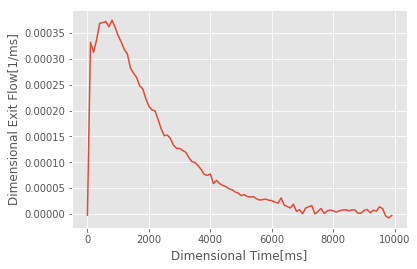

In [51]:
dimensional_time = np.zeros(data_points)
dimensional_exit_flow = np.zeros(data_points)
i = 0
j = 0
for line in open(data_file, "r"):
    if i%(10000/data_points)==0:
        data = line.split("\t")
        dimensional_time[j] = data[0]
        dimensional_exit_flow[j] = data[1]
        j += 1
    else:
        pass
    i += 1


print(len(dimensional_time), "\t", len(dimensional_exit_flow))
# print(dimensional_time, dimensional_exit_flow)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dimensional_time, dimensional_exit_flow)

ax.set_xlabel('Dimensional Time[ms]')
ax.set_ylabel('Dimensional Exit Flow[1/ms]')

plt.show()

## モデル依存のサンプリング

\begin{align}
    P\left(I_{\mu}\right) &= \prod_{\mu=1}^{T}\left(\sqrt{\frac{\alpha+\beta}{\pi}}\exp\left(-\left(\alpha + \beta\right)\left\{I_{\mu}-\frac{\alpha I_{\mu}^{M=0}+\beta I_{\mu}^{M=1}}{\alpha + \beta}\right\}^2\right)\right) \\
    &= \prod_{\mu=1}^{T}\left(\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{1}{2\sigma^2}\left\{I_{\mu}-\left(1-M\right)I_{\mu}^{M=0}-MI_{\mu}^{M=1}\right\}^{2} \right) \right) \\
    &= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^{T}\exp\left(-E\right) \\
    &= \exp\left(-E^{\prime}\right)
\end{align}

ただし
\begin{align}
    &\alpha = \frac{1-M}{2\sigma^{2}},\, 
    \beta = \frac{M}{2\sigma^{2}} \\
    E &= \frac{1}{2\sigma^{2}}\sum_{\mu=1}^{T}\left\{I_{\mu}-\left(1-M \right)I_{\mu}^{M=0}-MI_{\mu}^{M=1} \right\}^{2} \\
    E^{\prime} &= \frac{1}{2\sigma^{2}}\sum_{\mu=1}^{T}\left\{I_{\mu}-\left(1-M \right)I_{\mu}^{M=0}-MI_{\mu}^{M=1} \right\}^{2} + \frac{T}{2}\ln\left(2\pi\sigma^{2}\right)
\end{align}

$I_{\mu}$ は $F_{A}$

## 関数
```python:title
energy()
```
* 入力 : $M, D_{e}^{M=0}, D_{e}^{M=1}, k_{a}, k_{d}, \sigma$ ($\epsilon_{b}, L, t, F$ はあらかじめ指定)
* 出力 : 上記の $E^{\prime}$

In [52]:
def energy(model, diffusivity_0, diffusivity_1, k_a, k_d, std,
           epsilon=epsilon, length=length, 
           time=dimensional_time, artificial_flow=dimensional_exit_flow):

    
#    alpha = (1. - model)/(2.*std**2)
#    beta = model/(2.*std**2)
    
    Energy = np.square(artificial_flow - ((1.-model)*Flow(diffusivity=diffusivity_0,
                                                     k_a=0., k_d=0.,
                                                     epsilon=epsilon, length=length, 
                                                     time=time) + \
                                          model*Flow(diffusivity=diffusivity_1,
                                                     k_a=k_a, k_d=k_d, 
                                                     epsilon=epsilon, length=length, 
                                                     time=time))
                      ).sum()
    
    Energy *= 1./(2.*std**2)
    Energy += (time.shape[0]/2.) * np.log(2.*np.pi*std**2) 
    
    return Energy
        
#    return Energy, alpha, beta

#print(delta_energy(0, 1.5, 1.5, 20, 5, 5e-6, 5e-6))
#print(delta_energy(0.5, 1.5, 1.5, 20, 5, 5e-6, 5e-6))
print(energy(1, 1.5, 1.5, 20, 5, 5e-6))

-1080.82244507


## 遷移確率

\begin{align}
    r &= \frac{\hat{e}_{\beta}}{e^{\left(t\right)}_{\beta}} \\
    &= \frac{\exp \left(-\beta {\hat{E^{\prime}}}\right)}{\exp\left(-\beta E^{\prime (t)}\right)}\\
    &= \exp\left(-\beta\left({\hat{E^{\prime}}}-E^{\prime (t)}\right)\right)
\end{align}

## 関数
```python:title
r()
```
* 入力 : $\beta, \hat{M}, M^{\left(t\right)}, \hat{D_{e}^{M=0}}, \hat{D_{e}^{M=1}}, \hat{k_{a}}, \hat{k_{d}}, \hat{\sigma}, D_{e}^{M=0, \left(t\right)}, D_{e}^{M=1, \left(t\right)}, k_{a}^{\left(t\right)}, k_{d}^{\left(t\right)}, \sigma^{\left(t\right)}$ ($\epsilon_{b}, L, t, F_{A}$ はあらかじめ指定)
* 出力 : 遷移確率 $r$, $\hat{E^{\prime}}, E^{\prime(t)}$

In [53]:
def r(beta, model_cand, model_current,
       diffusivity_0_cand, diffusivity_1_cand, k_a_cand, k_d_cand, std_cand,
       diffusivity_0_current, diffusivity_1_current, k_a_current, k_d_current, std_current, 
       epsilon=epsilon, length=length, 
       time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
    E_cand = energy(model=model_cand,
                    diffusivity_0=diffusivity_0_cand,
                    diffusivity_1=diffusivity_1_cand,
                    k_a=k_a_cand, k_d=k_d_cand,
                    std=std_cand, 
                    epsilon=epsilon, length=length, 
                    time=time, artificial_flow=artificial_flow)
    
    E_current = energy(model=model_current, 
                       diffusivity_0=diffusivity_0_current,
                       diffusivity_1=diffusivity_1_current,
                       k_a=k_a_current, k_d=k_d_current,
                       std=std_current,
                       epsilon=epsilon, length=length, 
                       time=time, artificial_flow=artificial_flow)
    
    
    exponent = -E_cand + E_current
    
    return np.exp(beta*exponent), E_cand, E_current

print(r(1, 1, 1, 1.5, 1.5, 20., 5., 5e-6, 1.5, 1.499, 20, 5, 5e-6))

(1.0319700405173489, -1080.822445074808, -1080.7909754386765)


## 交換法

確率

\begin{align}
    r^{\prime} &= \frac{p^{M_{l}}_{\beta_{l}}\left(\hat{\theta}_{l+1}\right)p^{M_{l+1}}_{\beta_{l+1}}\left(\hat{\theta}_{l}\right)}{p^{M_{l}}_{\beta_{l}}\left(\hat{\theta}_{l}\right)p^{M_{l+1}}_{\beta_{l+1}}\left(\hat{\theta}_{l+1}\right)} \\
    &= \exp\left(-\beta_{l}E^{\prime}_{M_{l}}\left(\hat{\theta}_{l+1}\right)-\beta_{l+1}E^{\prime}_{M_{l+1}}\left(\hat{\theta}_{l}\right)+\beta_{l}E^{\prime}_{M_{l}}\left(\hat{\theta}_{l}\right)+\beta_{l+1}E^{\prime}_{M_{l+1}}\left(\hat{\theta}_{l+1}\right)\right)
\end{align}

でパラメータを交換

## 関数
```python;title
r_prime()
```
* 入力 : $\beta_l, \beta_{l+1}, M_{l}, D_{e, l}^{M=0}, D_{e, l}^{M=1}, k_{a, l}, k_{d, l}, \sigma_{l}, M_{l+1}, D_{e, l+1}^{M=0}, D_{e, l+1}^{M=1}, k_{a, l+1}, k_{d, l+1}, \sigma_{l+1}$ ($\epsilon_{b}, L, t, F$ はあらかじめ指定)
* 出力 : $r^{\prime}$

In [54]:
def r_prime(beta_l, beta_lplus1, model_l, diffusivity0_l, diffusivity1_l, k_a_l, k_d_l, std_l, 
            model_lplus1, diffusivity0_lplus1, diffusivity1_lplus1, k_a_lplus1, k_d_lplus1, std_lplus1, 
            epsilon=epsilon, length=length, time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
    E1 = energy(model=model_l, diffusivity_0=diffusivity0_lplus1, diffusivity_1=diffusivity1_lplus1,
                k_a=k_a_lplus1, k_d=k_d_lplus1, std=std_lplus1,
                epsilon=epsilon, length=length,
                time=dimensional_time, artificial_flow=dimensional_exit_flow)
    
    E2 = energy(model=model_lplus1, diffusivity_0=diffusivity0_l, diffusivity_1=diffusivity1_l,
                k_a=k_a_l, k_d=k_d_l, std=std_l,
                epsilon=epsilon, length=length, 
                time=dimensional_time, artificial_flow=dimensional_exit_flow)
        
    E3 = energy(model=model_l, diffusivity_0=diffusivity0_l, diffusivity_1=diffusivity1_l,
                k_a=k_a_l, k_d=k_d_l, std=std_l,
                epsilon=epsilon, length=length, 
                time=dimensional_time, artificial_flow=dimensional_exit_flow)
        
    E4 = energy(model=model_lplus1, diffusivity_0=diffusivity0_lplus1, diffusivity_1=diffusivity1_lplus1,
                k_a=k_a_lplus1, k_d=k_d_lplus1, std=std_lplus1,
                epsilon=epsilon, length=length,
                time=dimensional_time, artificial_flow=dimensional_exit_flow)
    
    E = -beta_l*E1-beta_lplus1*E2+beta_l*E3+beta_lplus1*E4
    
    return np.exp(E)

print(r_prime(1, 1, 0.9, 1.5, 1.5, 20, 5, 5e-6, 1.0, 1.5, 1.49, 20, 5, 5e-6))

3.05527036143e+23


## 対数ベイズ因子の計算によるモデル選択

対数ベイズ因子は
\begin{align}
    \ln\frac{P\left(M=1\,|\,{\bf{F}}^{data}\right)}{P\left(M=0\,|\,{\bf{F}}^{data}\right)} = \
    \int_{0}^{1}dM\left\langle\frac{d\ln P\left({\bf{F}}^{data}\,|\,\theta, M\right)}{dM} \right\rangle_{M}
\end{align}

ただし被積分関数は

\begin{align}
    \left\langle\frac{d\ln P\left({\bf{F}}^{data}\,|\,\theta, M\right)}{dM} \right\rangle_{M} &= -\frac{d}{dM}E^{\prime} \\
    &= -\frac{1}{\sigma^{2}}\sum_{\mu=1}^{T}\left(I_{\mu}^{M=0}-I_{\mu}^{M=1}\right)\left\{I_{\mu}^{data}-\left(1-M\right)I_{\mu}^{M=0}-MI_{\mu}^{M=1}\right\}
\end{align}

と書ける。パラメータのサンプリング結果から被積分関数を数値的に求め，対数ベイズ因子を計算することによりモデル選択を行う。

## 対数ベイズ因子の被積分関数の計算
```python;title
dlog_p
```
* input : $M, D_e^{(M=0)}, D_e^{(M=1}, k_a, k_d, \sigma$ (全てスカラー)　
* output : 被積分関数 dlog (スカラー)

In [55]:
def dlog_p(model, diffusivity_0, diffusivity_1, k_a, k_d, 
           std, time=dimensional_time, artificial_flow=dimensional_exit_flow, 
           epsilon=epsilon, length=length):
    
    dlogp = -1./(std**2) \
            *(
                 (Flow(diffusivity=diffusivity_0, k_a=0, k_d=0, time=time, epsilon=epsilon, length=length) \
                  - Flow(diffusivity=diffusivity_1, k_a=k_a, k_d=k_d, time=time, epsilon=epsilon, length=length)) \
                 *(artificial_flow - (1-model)*Flow(diffusivity=diffusivity_0,
                                                    k_a=0, k_d=0,
                                                    time=time, epsilon=epsilon, length=length) \
                   - model*Flow(diffusivity=diffusivity_1, 
                                k_a=k_a, k_d=k_d, 
                                time=time, epsilon=epsilon, length=length)\
                   )
              ).sum()
           
    return dlogp

print(dlog_p(1, 1.49, 1.5, 20, 5, 5*10**-6))

-799.412150232


## ファイルからの読み込み
```python;title
file_output()
```
* 入力 : file_name, T[mcs], $M$(モデルパラメータ)
* 出力 : $D_e^{(M=0)}, D_e^{(M=1)}, k_a, k_d, \sigma, E, dlogp$, pick, update, exchange rate ($\theta$.shape=(M, T))

In [56]:
def file_output(file, T, model):
    
    diffusivity_0 = np.zeros([model.shape[0], T])
    diffusivity_1 = np.zeros([model.shape[0], T])
    k_a = np.zeros([model.shape[0], T])
    k_d = np.zeros([model.shape[0], T])
    sigma_0 = np.zeros([model.shape[0], T])
    E = np.zeros([model.shape[0], T])

    dlogp = np.zeros([model.shape[0], T])
    
    pick = np.zeros([model.shape[0], 5])
    update = np.zeros([model.shape[0], 5])
    exchange_rate = np.zeros(model.shape[0]-1)
    
    l = 0; m = 0; t = 0; m_ = 0
    for line in open(file, "r"):
        data = line.split("\t")
        try :
            tmp = float(data[0])
            if 1<=l<=model.shape[0]:
                for i in range(5):
                    pick[m_, i] = float(data[i])
                m_ += 1
            elif (model.shape[0]+2)<=l<=(2*model.shape[0]+1):
                for i in range(5):
                    update[m_, i] = float(data[i])
                m_ += 1
            elif l==(2*model.shape[0]+4):
                for i in range(model.shape[0]-1):
                    exchange_rate[i] = float(data[i])
            else:
                diffusivity_0[m, t] = data[0]
                diffusivity_1[m, t] = data[1]
                k_a[m, t] = data[2]
                k_d[m, t] = data[3]
                sigma_0[m, t] = data[4]
                E[m, t] = data[5]
                dlogp[m, t] = data[6]
                t += 1
        except :
            pass
        else :
            if t==T:
                m += 1
                t = 0
            if m_==model.shape[0]:
                m_ = 0
        finally :
            l += 1
            
    return diffusivity_0, diffusivity_1, k_a, k_d, sigma_0, E, dlogp, pick, update, exchange_rate

In [69]:
d0, d1, ka, kd, sigma, e, dp, pick, up, ex = file_output(read_file, T, np.hstack((beta, beta)))

In [58]:
# for i in range(np.hstack((beta, beta)).shape[0]):
#     print(e[i][T-1])

## 交換法のアルゴリズム

```python;title
exchange_monte_calro()
```
* 入力 : モンテカルロステップ数，逆温度$\beta$，モデルパラメータ$M$($\beta, M$は配列)
* 出力 : $D_e^{(M=0)}, D_e^{(M=1)}, k_a, k_d, \sigma, E^{\prime}, dlogp$　((`model.shape[0]`, $T$)の2次元配列), pick, update, exchange_rate

In [70]:
def exchange_monte_calro(monte_calro_step, beta, model,
                         d0, d1, ka, kd, std, e,
                         epsilon=epsilon, length=length, 
                         time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
    diffusivity_0 = np.zeros([2*beta.shape[0], monte_calro_step])
    diffusivity_1 = np.zeros([2*beta.shape[0], monte_calro_step])
    k_a = np.zeros([2*beta.shape[0], monte_calro_step])
    k_d = np.zeros([2*beta.shape[0], monte_calro_step])
    sigma = np.zeros([2*beta.shape[0], monte_calro_step])
    Energy = np.zeros([2*beta.shape[0], monte_calro_step])
    pick = np.zeros([2*beta.shape[0], 5]); update = np.zeros([2*beta.shape[0], 5])
    exchange_count = np.zeros(2*beta.shape[0]-1)
    
    """initialize parameters"""
    
    for i in range(2*beta.shape[0]):
        diffusivity_0[i, 0] = d0[i][monte_calro_step-1]
        diffusivity_1[i, 0] = d1[i][monte_calro_step-1]
        k_a[i, 0] = ka[i][monte_calro_step-1]
        k_d[i, 0] = kd[i][monte_calro_step-1]
        sigma[i, 0] = std[i][monte_calro_step-1]
        Energy[i, 0] = e[i][monte_calro_step-1]
#        Energy[i, 0] = energy(0, diffusivity_0[i, 0], diffusivity_1[i, 0], k_a[i, 0], k_d[i, 0], sigma[i, 0])

#        print(Energy[i, 0])
    
    t = 1

    while t < monte_calro_step:
        """update parameters"""
        for b in range(2*beta.shape[0]):
            diffusivity_0[b, t] = diffusivity_0[b, t-1]; diffusivity_1[b, t] = diffusivity_1[b, t-1]
            k_a[b, t] = k_a[b, t-1]; k_d[b, t] = k_d[b, t-1]; sigma[b, t] = sigma[b, t-1]
            Energy[b, t] = Energy[b, t-1]
            
            choice = np.random.randint(0, 5); pick[b, choice] += 1
            if choice == 0:
                diffusivity_0[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
            elif choice == 1:
                diffusivity_1[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
            elif choice == 2:
                k_a[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
            elif choice == 3:
                k_d[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
            elif choice == 4:
                sigma[b, t] += stats.uniform.rvs(loc=-1e-6, scale=2e-6)
            
            if b+1 <= beta.shape[0]:
                model = 0
                inv_temp = beta[b]
            else:
                model = 1
                inv_temp = beta[2*beta.shape[0]-1-b]
            
            
#            print('model=',model, 'beta=', inv_temp)
            transition_prob, e_cand, e_current = r(inv_temp, model, model,
                                                   diffusivity_0[b, t], diffusivity_1[b, t],
                                                   k_a[b, t], k_d[b, t], sigma[b, t],
                                                   diffusivity_0[b, t-1], diffusivity_1[b, t-1],
                                                   k_a[b, t-1], k_d[b, t-1], sigma[b, t-1])
                    
            if np.array([1.0, transition_prob]).min() > stats.uniform.rvs():
                Energy[b, t] = e_cand
                update[b, choice] += 1
            else:
                diffusivity_0[b, t] = diffusivity_0[b, t-1]; diffusivity_1[b, t] = diffusivity_1[b, t-1]
                k_a[b, t] = k_a[b, t-1]; k_d[b, t] = k_d[b, t-1]; sigma[b, t] = sigma[b, t-1]
        
        """exchange parameters"""
        for b in range(2*beta.shape[0]-1):
            if b < beta.shape[0]-1:
                beta_l, beta_lplus1 = beta[b], beta[b+1]
                model_l, model_lplus1 = 0., 0.
            elif b == beta.shape[0]-1:
                beta_l, beta_lplus1 = beta[b], beta[b]
                model_l, model_lplus1 = 0., 1.0
            elif b > beta.shape[0]-1:
                beta_l, beta_lplus1 = beta[2*beta.shape[0]-1-b], beta[2*beta.shape[0]-1-b-1]
                model_l, model_lplus1 = 1.0, 1.0
            
            exchange_prob = r_prime(beta_l, beta_lplus1,
                                    model_l, diffusivity_0[b, t], diffusivity_1[b, t],
                                    k_a[b, t], k_d[b, t], sigma[b, t], 
                                    model_lplus1, diffusivity_0[b+1, t], diffusivity_1[b+1, t],
                                    k_a[b+1, t], k_d[b+1, t], sigma[b+1, t])
            
            if np.array([1.0, exchange_prob]).min() > stats.uniform.rvs():
                diffusivity_0[b, t], diffusivity_0[b+1, t] = diffusivity_0[b+1, t], diffusivity_0[b, t]
                diffusivity_1[b, t], diffusivity_1[b+1, t] = diffusivity_1[b+1, t], diffusivity_1[b, t]
                k_a[b, t], k_a[b+1, t] = k_a[b+1, t], k_a[b, t]; k_d[b, t], k_d[b+1, t] = k_d[b+1, t], k_d[b, t]
                sigma[b, t], sigma[b+1, t] = sigma[b+1, t], sigma[b, t]
                Energy[b, t], Energy[b+1, t] = Energy[b+1, t], Energy[b, t]
                exchange_count[b] += 1
 
        t += 1
                
    return diffusivity_0, diffusivity_1, k_a, k_d, sigma, Energy, pick, update, exchange_count

In [71]:
# d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(2, beta, [0, 1], d0, d1, ka, kd, sigma, e)
# # print(e)
# print(pick)
# print(update)
# print(update.sum(axis=1)/100)
# print(exchange_count)

In [74]:
def file_write(w_file, beta, model, diffusivity_0, diffusivity_1, k_a, k_d, sigma, E, dlogp, pick, update, exchange):
    
    with open(w_file, "w") as fileobj:
                
        fileobj.write(str('#model parametes M, temperature \n'))
        for i in range(model.shape[0]):
            for j in range(beta.shape[0]):
                if i==0 and j==0:
                    fileobj.write('#(M, Temp)=({}, {})'.format(model[i], temp[j])); fileobj.write(str('\t'))
                elif i==0:
                    fileobj.write('({}, {})'.format(model[i], temp[j])); fileobj.write(str('\t'))
                elif i==1:
                    fileobj.write('({}, {})'.format(model[i], temp[beta.shape[0]-1-j])); fileobj.write(str('\t'))
        fileobj.write(str('\n \n'))

        fileobj.write(str("#acceptance rate\n"))
        for m in range(2*beta.shape[0]):
            for i in range(5):
                fileobj.write(str(pick[m, i])); fileobj.write(str("\t"))
            fileobj.write(str("\n"))
        fileobj.write(str("\n"))
        fileobj.write(str('#update \n'))
        for m in range(2*beta.shape[0]):
            for i in range(5):
                fileobj.write(str(update[m, i])); fileobj.write(str("\t"))
            fileobj.write(str("\n"))
        fileobj.write(str("\n"))

        fileobj.write(str("#exchange rate\n"))
        for m in range(2*beta.shape[0]-1):
            fileobj.write(str(exchange[m])); fileobj.write(str("\t"))
        fileobj.write(str("\n")); fileobj.write(str("\n"))

        fileobj.write(str('De^M=0, De^M=1, ka, kd, sigma, energy, log bayes f\n'))
        for b in range(2*beta.shape[0]):
            if b < beta.shape[0]:
                fileobj.write(str("#M={}, beta={}\n".format(0, beta[b])))
            else:
                fileobj.write(str("#M={}, beta={}\n".format(1, beta[2*beta.shape[0]-1-b])))
            for i in range(T):
                fileobj.write(str(diffusivity_0[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(diffusivity_1[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(k_a[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(k_d[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(sigma[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(E[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(dlogp[b, i])); fileobj.write(str("\t"))
                fileobj.write(str("\n"))
            fileobj.write(str("\n"))
            
    return

In [73]:
dlogp = np.zeros([2*beta.shape[0], T])#######################

for i in range(sample):
    w_file = 'EM_TAP_test_M11_sigma_{}.dat'.format(i)
    
    diffusivity_0, diffusivity_1, k_a, k_d, sigma, E, pick, update, exchange\
    = exchange_monte_calro(T, beta, np.array([0, 1]), d0, d1, ka, kd, sigma, e)
    
    file_write(w_file, beta, np.array([0, 1]), diffusivity_0, diffusivity_1, k_a, k_d, sigma, E, dlogp, pick, update, exchange)

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
